<a href="https://colab.research.google.com/github/eridanletalis/GB_nn/blob/main/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

План работы:
1. Загрузить датасет "птицы"
2. Использовать датасет с сетью из 4х блоков
3. Использовать датасет с сетью из 5 блоков
4. Использовать датасет с предобученными весами vgg16
5. Использовтаь датасет с сетью с предобученными весами vgg19

**Результаты:**
По vgg19  результат на 30 эпохе
val_loss: 0.0399 - val_dice_coef: 0.9465
Перестало сильно сходиться уже к 15

По vgg16 результат на 30 эпохе
val_loss: 0.0425 - val_dice_coef: 0.9422
результат на 60 эпохе 
val_loss: 0.0238 - val_dice_coef: 0.9671
Тест менее стабильно сходится, но на 30-40 можно было останавливать (наверное)

Порядок результатов на этих предтенированных сетях к 30 эпохе примерно одинаков.

Были получены навыки использования заранее обученных сетей, что плюс.

Запомнить, что для одного класса использовать сигмоиду (релу, наверное, тоже подойдёт) и бинарную кроссэнтропию, для нескольких классов - софтмакс, чтобы получить вероятности, и категориальную кроссэнтропию.

Эксперименты с обучением с нуля дали очень слабые результаты и проводились долго. 

**Вывод:** в любой непонятной ситуации сначала попробовать несколько предтренированных ИНС

Исследование ниже.

In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
from tqdm import tqdm_notebook, tqdm
from skimage.draw import ellipse, polygon

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.losses import binary_crossentropy
import tensorflow as tf
import keras as keras

from keras import backend as K

from tqdm import tqdm_notebook

In [2]:
# определяем функции потерь и точности
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'bce_dice_loss': bce_dice_loss })
get_custom_objects().update({'dice_loss': dice_loss })
get_custom_objects().update({'dice_coef': dice_coef })
get_custom_objects().update({'my_iou_metric': my_iou_metric })

In [3]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf
import os
import scipy.io
import cv2

#Загрузка датасета

In [4]:
PATH = '/content/drive/MyDrive/Datasets/birds'
path_annotations = PATH + '//annotations'
path_image = PATH + '//image'

In [5]:
# Сначала сделаем один архив датасет "птицы" и убедимся, что работает
# для примера ограничим количество образцов 15ю папками
images = []
segments = []
image_size = (128,128)
k=100
for dir in os.listdir(path_image):
  lbl = dir
  img_path = path_image + '//' + dir
  segm_path = path_annotations + '//' + dir
  # print('*'*50)
  if k < 0:
    break
  else:
    k -= 1
  print(lbl)
  for i in os.listdir(img_path):
    if i[0] != '.':
      #print(i)
      annot_file = segm_path + '//' + i[:-3] + 'mat'
      if not os.path.exists(annot_file):
        #print('Annot not exist: ' + annot_file)
        pass
      else:
        mat = scipy.io.loadmat(annot_file)
        images.append(image.load_img(img_path + '//' + i ,target_size=image_size))
        seg = image.array_to_img(mat["seg"].astype(np.float)[:,:,np.newaxis]).resize(image_size)
        seg_array = image.img_to_array(seg, dtype=np.float) / 255.0
        segments.append(seg_array)
        # plt.imshow(image.load_img(img_path + '//' + i))
        # plt.show()
        # plt.imshow(mat["seg"])
        # plt.show()
      #

  #print('*'*50)

190.Red_cockaded_Woodpecker
188.Pileated_Woodpecker
195.Carolina_Wren
187.American_Three_toed_Woodpecker
196.House_Wren
192.Downy_Woodpecker
191.Red_headed_Woodpecker
194.Cactus_Wren
193.Bewick_Wren
189.Red_bellied_Woodpecker
002.Laysan_Albatross
006.Least_Auklet
003.Sooty_Albatross
004.Groove_billed_Ani
001.Black_footed_Albatross
005.Crested_Auklet
199.Winter_Wren
200.Common_Yellowthroat
198.Rock_Wren
197.Marsh_Wren
013.Bobolink
012.Yellow_headed_Blackbird
016.Painted_Bunting
015.Lazuli_Bunting
009.Brewer_Blackbird
007.Parakeet_Auklet
011.Rusty_Blackbird
008.Rhinoceros_Auklet
014.Indigo_Bunting
010.Red_winged_Blackbird
026.Bronzed_Cowbird
023.Brandt_Cormorant
025.Pelagic_Cormorant
019.Gray_Catbird
024.Red_faced_Cormorant
020.Yellow_breasted_Chat
017.Cardinal
018.Spotted_Catbird
021.Eastern_Towhee
022.Chuck_will_Widow
028.Brown_Creeper
035.Purple_Finch
029.American_Crow
031.Black_billed_Cuckoo
027.Shiny_Cowbird
032.Mangrove_Cuckoo
034.Gray_crowned_Rosy_Finch
036.Northern_Flicker
030.Fi

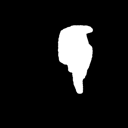

In [6]:
# проверим, что загружено правильно
test = image.array_to_img(segments[2])

test

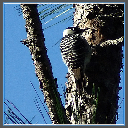

In [7]:
images[2]


In [8]:
# собираем общий набор
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [9]:
yTrain_Test = []

for seg in segments:
  y_cat = seg
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

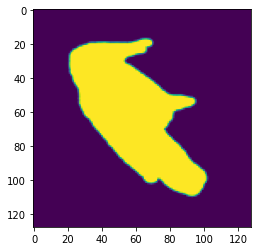

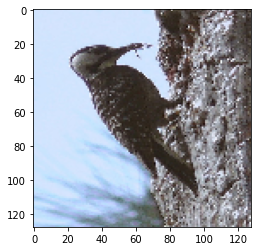

In [10]:
# проврим, что набор собран правильно и происходит сопоставление 1 к 1 для 
# примеров и масок
n = 20
# plt.imshow(yTrain_Test[n].convert('RGBA'))
# plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()
plt.imshow(xTrain_Test[n].astype(int))
plt.show()

In [11]:
# делим на тест и трейн. 
prop = 15
N = int(xTrain_Test.shape[0] * 0.15)

yTrain = yTrain_Test[N:,:,:,:]
xTrain = xTrain_Test[N:,:,:,:]

yTest = yTrain_Test[:N,:,:,:]
xTest = xTrain_Test[:N,:,:,:]

#Использование с "короткой" сетью

In [12]:
def cuttedUnetA(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [13]:
modelA = cuttedUnetA(1, (128, 128, 3))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

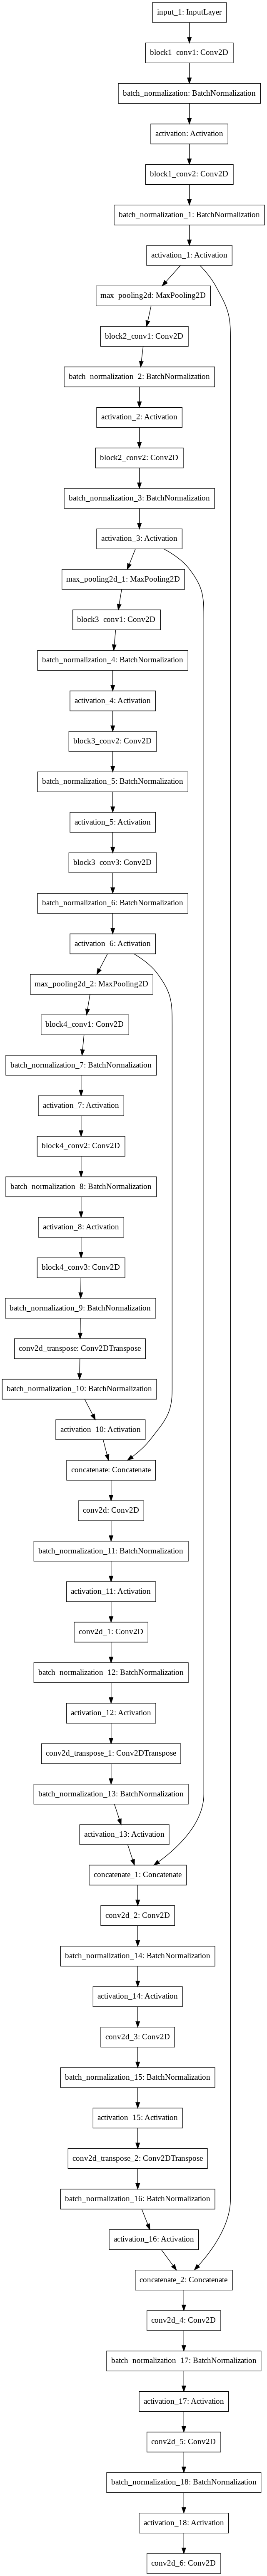

In [14]:
tf.keras.utils.plot_model(modelA)

In [15]:
history = modelA.fit(xTrain, yTrain, epochs=20, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/20
2560/2560 [==============================] - 315s 110ms/step - loss: 0.3289 - dice_coef: 0.4869 - val_loss: 0.4300 - val_dice_coef: 0.5434
Epoch 2/20
2560/2560 [==============================] - 281s 110ms/step - loss: 0.2472 - dice_coef: 0.6627 - val_loss: 0.3490 - val_dice_coef: 0.5634
Epoch 3/20
2560/2560 [==============================] - 280s 109ms/step - loss: 0.2236 - dice_coef: 0.6906 - val_loss: 0.3182 - val_dice_coef: 0.4283
Epoch 4/20
2560/2560 [==============================] - 281s 110ms/step - loss: 0.2125 - dice_coef: 0.7141 - val_loss: 0.3250 - val_dice_coef: 0.5272
Epoch 5/20
2560/2560 [==============================] - 281s 110ms/step - loss: 0.1930 - dice_coef: 0.7366 - val_loss: 0.3542 - val_dice_coef: 0.5401
Epoch 6/20
2560/2560 [==============================] - 281s 110ms/step - loss: 0.1853 - dice_coef: 0.7570 - val_loss: 0.3104 - val_dice_coef: 0.4830
Epoch 7/20
2560/2560 [==============================] - 280s 109ms/step - loss: 0.1690 - dice_coef: 

In [16]:
pred = modelA.predict(xTest)
print(pred.shape)

(451, 128, 128, 1)


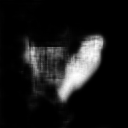

In [17]:
image.array_to_img(pred[4])

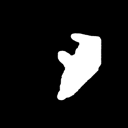

In [18]:
image.array_to_img(yTest[4])

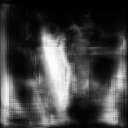

In [19]:
image.array_to_img(pred[2])

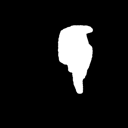

In [20]:
image.array_to_img(yTest[2])

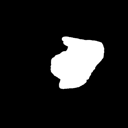

In [21]:
image.array_to_img(yTest[3])

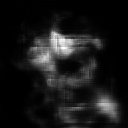

In [22]:
image.array_to_img(pred[3])

Так как загрузка происходит правильно, попробуем поэкспериментировать.

#Использование с "динной" сетью

In [23]:
# попробуем увеличить количество слоёв

In [24]:
def cuttedUnetB(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    #Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [25]:
modelB = cuttedUnetB(1, (128, 128, 3))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 64) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

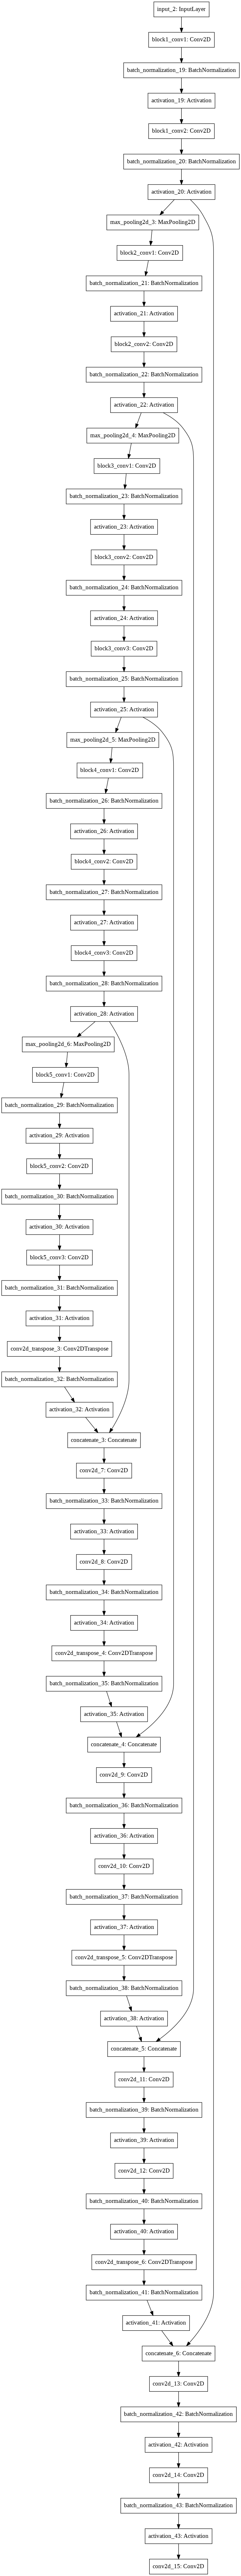

In [26]:
tf.keras.utils.plot_model(modelB)

In [27]:
history = modelB.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
2560/2560 [==============================] - 392s 152ms/step - loss: 0.3084 - dice_coef: 0.5410 - val_loss: 0.3388 - val_dice_coef: 0.4545
Epoch 2/10
2560/2560 [==============================] - 388s 152ms/step - loss: 0.2355 - dice_coef: 0.6774 - val_loss: 0.3266 - val_dice_coef: 0.4974
Epoch 3/10
2560/2560 [==============================] - 386s 151ms/step - loss: 0.2179 - dice_coef: 0.7024 - val_loss: 0.2946 - val_dice_coef: 0.4150
Epoch 4/10
2560/2560 [==============================] - 387s 151ms/step - loss: 0.1889 - dice_coef: 0.7311 - val_loss: 0.3174 - val_dice_coef: 0.5158
Epoch 5/10
2560/2560 [==============================] - 388s 151ms/step - loss: 0.1805 - dice_coef: 0.7504 - val_loss: 0.3294 - val_dice_coef: 0.3715
Epoch 6/10
2560/2560 [==============================] - 387s 151ms/step - loss: 0.1715 - dice_coef: 0.7628 - val_loss: 0.2938 - val_dice_coef: 0.5500
Epoch 7/10
2560/2560 [==============================] - 388s 152ms/step - loss: 0.1623 - dice_coef: 

In [28]:
pred = modelB.predict(xTest)
print(pred.shape)

(451, 128, 128, 1)


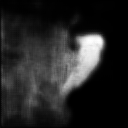

In [29]:
image.array_to_img(pred[4])

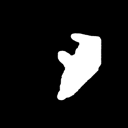

In [30]:
image.array_to_img(yTest[4])

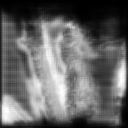

In [31]:
image.array_to_img(pred[2])

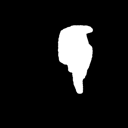

In [32]:
image.array_to_img(yTest[2])

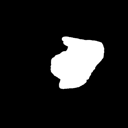

In [33]:
image.array_to_img(yTest[3])

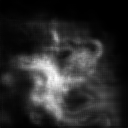

In [34]:
image.array_to_img(pred[3])

In [35]:
# попробуем использовать первую предтерированную сеть

#Использование с VGG16

In [36]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 0s 0us/step


In [37]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [38]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    # всем слоям, которые обучаемы, говорим, что они заморожены
    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [39]:
modelC = unet_pre_train(num_classes = 1, input_shape= (128, 128, 3))


KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_4[0][0]            

In [40]:
from IPython.display import clear_output

In [41]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])
    k = Ipred.shape[3]
    print('Predict')
    plt.figure(figsize = (10*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (10*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(yTest[0,:,:,i])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/60
854/854 [==============================] - 100s 112ms/step - loss: 0.3156 - dice_coef: 0.4968 - val_loss: 0.3243 - val_dice_coef: 0.6666
Predict


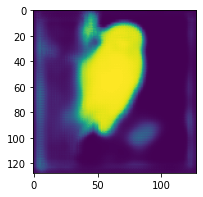

True


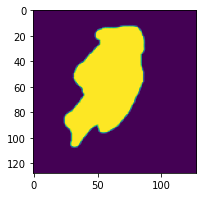


Sample Prediction after epoch 1

Epoch 2/60
854/854 [==============================] - 94s 111ms/step - loss: 0.1825 - dice_coef: 0.7743 - val_loss: 0.2096 - val_dice_coef: 0.7790
Predict


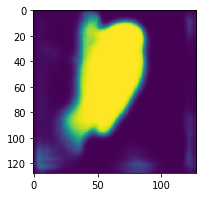

True


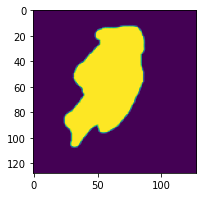


Sample Prediction after epoch 2

Epoch 3/60
854/854 [==============================] - 94s 111ms/step - loss: 0.1574 - dice_coef: 0.8080 - val_loss: 0.1347 - val_dice_coef: 0.8300
Predict


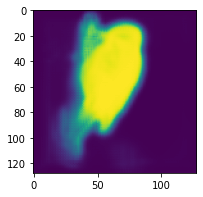

True


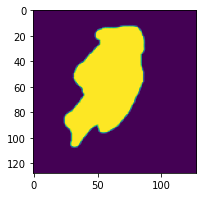


Sample Prediction after epoch 3

Epoch 4/60
854/854 [==============================] - 94s 111ms/step - loss: 0.1384 - dice_coef: 0.8265 - val_loss: 0.1519 - val_dice_coef: 0.7853
Predict


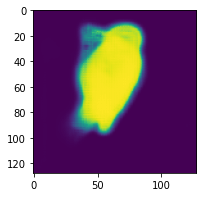

True


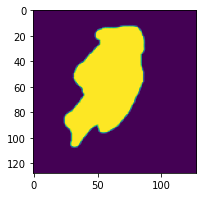


Sample Prediction after epoch 4

Epoch 5/60
854/854 [==============================] - 95s 111ms/step - loss: 0.1313 - dice_coef: 0.8339 - val_loss: 0.1151 - val_dice_coef: 0.8575
Predict


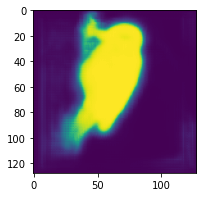

True


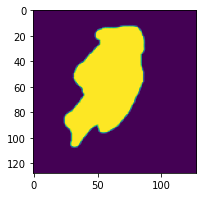


Sample Prediction after epoch 5

Epoch 6/60
854/854 [==============================] - 95s 111ms/step - loss: 0.1104 - dice_coef: 0.8637 - val_loss: 0.1721 - val_dice_coef: 0.7271
Predict


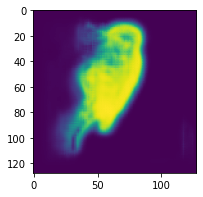

True


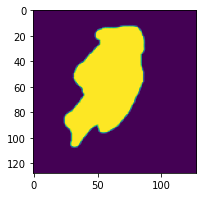


Sample Prediction after epoch 6

Epoch 7/60
854/854 [==============================] - 95s 112ms/step - loss: 0.1003 - dice_coef: 0.8743 - val_loss: 0.0932 - val_dice_coef: 0.8820
Predict


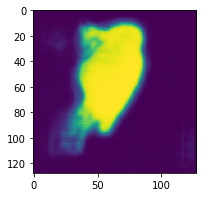

True


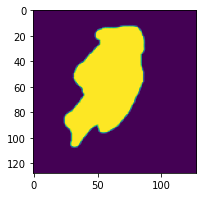


Sample Prediction after epoch 7

Epoch 8/60
854/854 [==============================] - 95s 112ms/step - loss: 0.0935 - dice_coef: 0.8836 - val_loss: 0.0835 - val_dice_coef: 0.8905
Predict


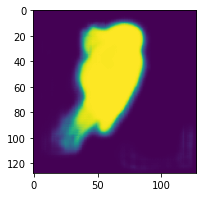

True


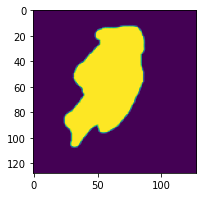


Sample Prediction after epoch 8

Epoch 9/60
854/854 [==============================] - 95s 112ms/step - loss: 0.0870 - dice_coef: 0.8895 - val_loss: 0.0772 - val_dice_coef: 0.8988
Predict


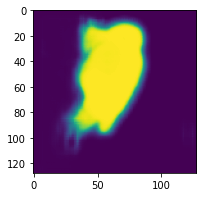

True


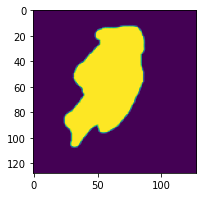


Sample Prediction after epoch 9

Epoch 10/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0793 - dice_coef: 0.8998 - val_loss: 0.0823 - val_dice_coef: 0.8840
Predict


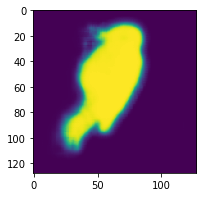

True


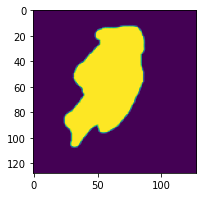


Sample Prediction after epoch 10

Epoch 11/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0736 - dice_coef: 0.9028 - val_loss: 0.0822 - val_dice_coef: 0.8947
Predict


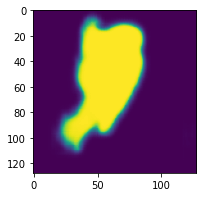

True


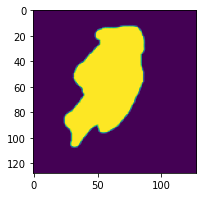


Sample Prediction after epoch 11

Epoch 12/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0711 - dice_coef: 0.9054 - val_loss: 0.1626 - val_dice_coef: 0.8271
Predict


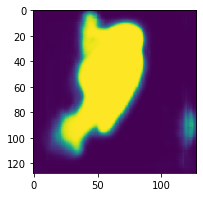

True


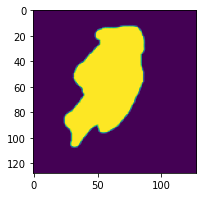


Sample Prediction after epoch 12

Epoch 13/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0733 - dice_coef: 0.9075 - val_loss: 0.0704 - val_dice_coef: 0.9078
Predict


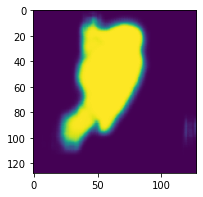

True


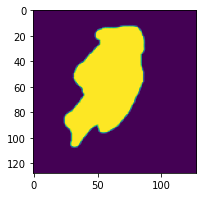


Sample Prediction after epoch 13

Epoch 14/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0675 - dice_coef: 0.9107 - val_loss: 0.0810 - val_dice_coef: 0.8886
Predict


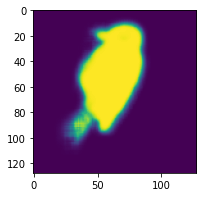

True


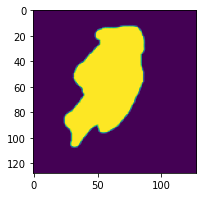


Sample Prediction after epoch 14

Epoch 15/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0653 - dice_coef: 0.9152 - val_loss: 0.0731 - val_dice_coef: 0.9046
Predict


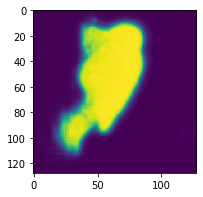

True


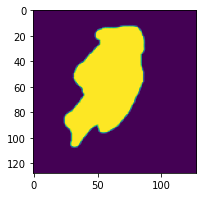


Sample Prediction after epoch 15

Epoch 16/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0773 - dice_coef: 0.9025 - val_loss: 0.0618 - val_dice_coef: 0.9183
Predict


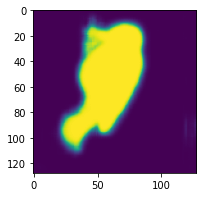

True


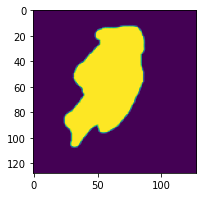


Sample Prediction after epoch 16

Epoch 17/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0586 - dice_coef: 0.9199 - val_loss: 0.0566 - val_dice_coef: 0.9244
Predict


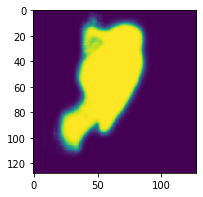

True


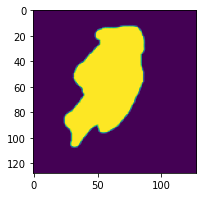


Sample Prediction after epoch 17

Epoch 18/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0570 - dice_coef: 0.9232 - val_loss: 0.0629 - val_dice_coef: 0.9130
Predict


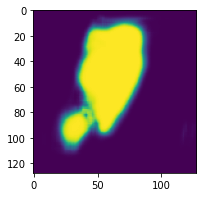

True


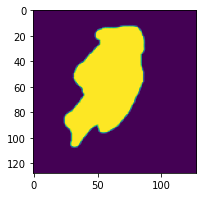


Sample Prediction after epoch 18

Epoch 19/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0564 - dice_coef: 0.9252 - val_loss: 0.0552 - val_dice_coef: 0.9257
Predict


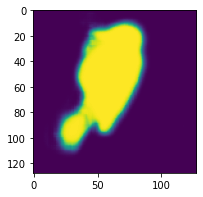

True


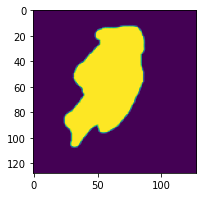


Sample Prediction after epoch 19

Epoch 20/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0556 - dice_coef: 0.9240 - val_loss: 0.0764 - val_dice_coef: 0.9035
Predict


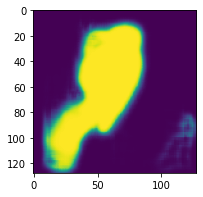

True


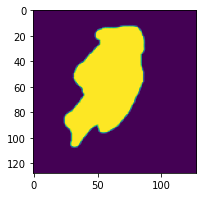


Sample Prediction after epoch 20

Epoch 21/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0582 - dice_coef: 0.9236 - val_loss: 0.0545 - val_dice_coef: 0.9252
Predict


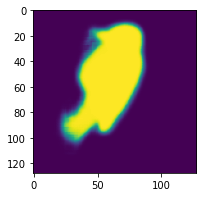

True


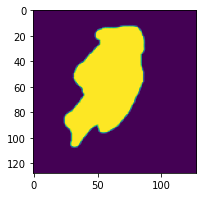


Sample Prediction after epoch 21

Epoch 22/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0519 - dice_coef: 0.9287 - val_loss: 0.0509 - val_dice_coef: 0.9298
Predict


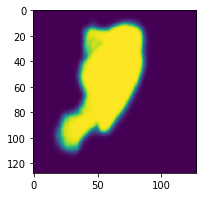

True


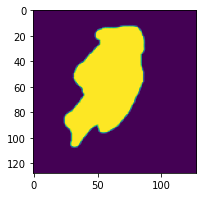


Sample Prediction after epoch 22

Epoch 23/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0523 - dice_coef: 0.9304 - val_loss: 0.0559 - val_dice_coef: 0.9254
Predict


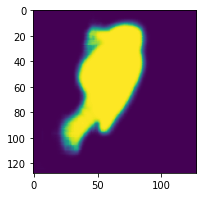

True


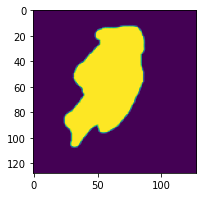


Sample Prediction after epoch 23

Epoch 24/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0493 - dice_coef: 0.9323 - val_loss: 0.0490 - val_dice_coef: 0.9325
Predict


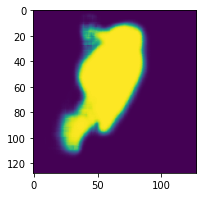

True


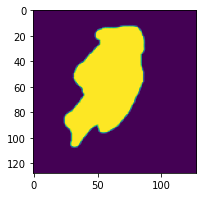


Sample Prediction after epoch 24

Epoch 25/60
854/854 [==============================] - 95s 112ms/step - loss: 0.0482 - dice_coef: 0.9335 - val_loss: 0.0507 - val_dice_coef: 0.9318
Predict


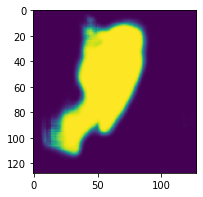

True


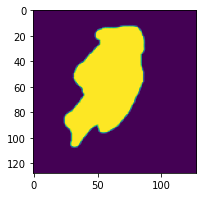


Sample Prediction after epoch 25

Epoch 26/60
854/854 [==============================] - 95s 112ms/step - loss: 0.0503 - dice_coef: 0.9313 - val_loss: 0.0464 - val_dice_coef: 0.9368
Predict


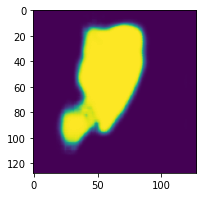

True


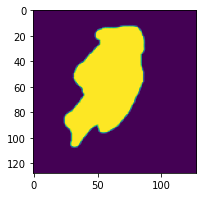


Sample Prediction after epoch 26

Epoch 27/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0475 - dice_coef: 0.9362 - val_loss: 0.0471 - val_dice_coef: 0.9350
Predict


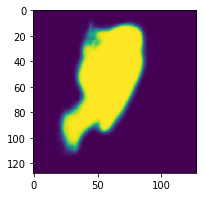

True


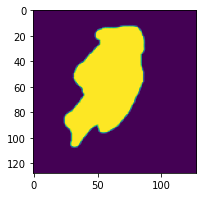


Sample Prediction after epoch 27

Epoch 28/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0490 - dice_coef: 0.9347 - val_loss: 0.0427 - val_dice_coef: 0.9421
Predict


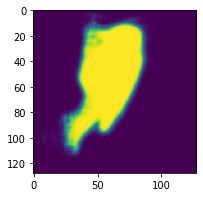

True


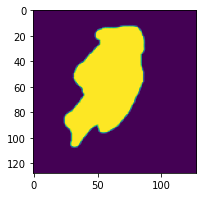


Sample Prediction after epoch 28

Epoch 29/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0433 - dice_coef: 0.9408 - val_loss: 0.0434 - val_dice_coef: 0.9410
Predict


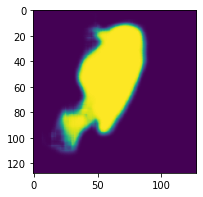

True


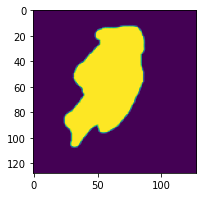


Sample Prediction after epoch 29

Epoch 30/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0436 - dice_coef: 0.9415 - val_loss: 0.0425 - val_dice_coef: 0.9422
Predict


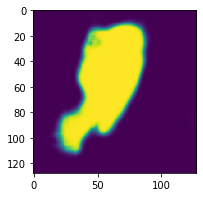

True


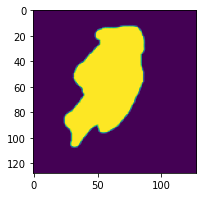


Sample Prediction after epoch 30

Epoch 31/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0423 - dice_coef: 0.9433 - val_loss: 0.0452 - val_dice_coef: 0.9364
Predict


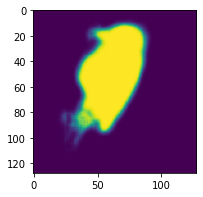

True


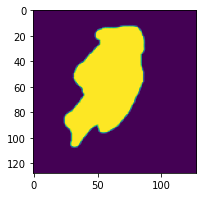


Sample Prediction after epoch 31

Epoch 32/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0411 - dice_coef: 0.9434 - val_loss: 0.0426 - val_dice_coef: 0.9412
Predict


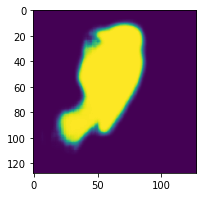

True


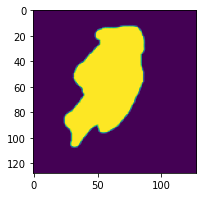


Sample Prediction after epoch 32

Epoch 33/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0517 - dice_coef: 0.9300 - val_loss: 0.0388 - val_dice_coef: 0.9466
Predict


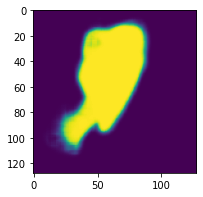

True


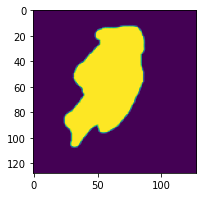


Sample Prediction after epoch 33

Epoch 34/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0386 - dice_coef: 0.9473 - val_loss: 0.0367 - val_dice_coef: 0.9498
Predict


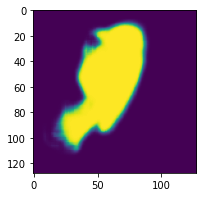

True


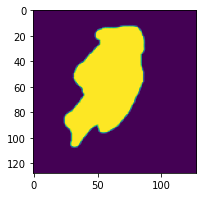


Sample Prediction after epoch 34

Epoch 35/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0382 - dice_coef: 0.9483 - val_loss: 0.0371 - val_dice_coef: 0.9482
Predict


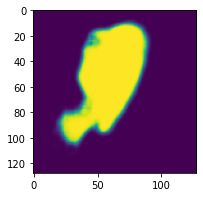

True


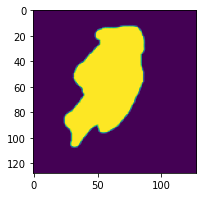


Sample Prediction after epoch 35

Epoch 36/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0361 - dice_coef: 0.9496 - val_loss: 0.0355 - val_dice_coef: 0.9504
Predict


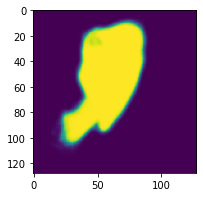

True


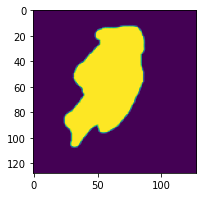


Sample Prediction after epoch 36

Epoch 37/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0372 - dice_coef: 0.9489 - val_loss: 0.0396 - val_dice_coef: 0.9461
Predict


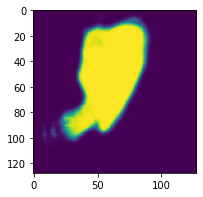

True


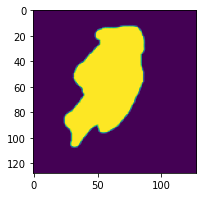


Sample Prediction after epoch 37

Epoch 38/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0363 - dice_coef: 0.9502 - val_loss: 0.0376 - val_dice_coef: 0.9488
Predict


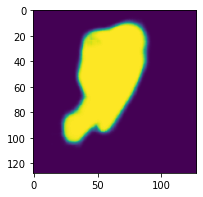

True


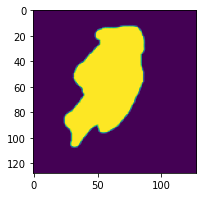


Sample Prediction after epoch 38

Epoch 39/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0353 - dice_coef: 0.9513 - val_loss: 0.0361 - val_dice_coef: 0.9487
Predict


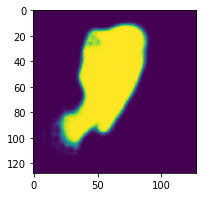

True


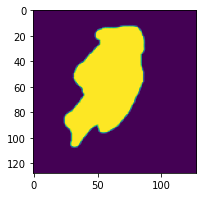


Sample Prediction after epoch 39

Epoch 40/60
854/854 [==============================] - 95s 112ms/step - loss: 0.0340 - dice_coef: 0.9536 - val_loss: 0.0324 - val_dice_coef: 0.9555
Predict


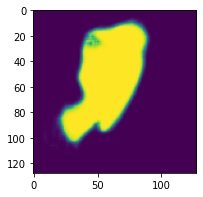

True


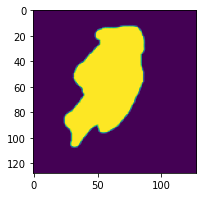


Sample Prediction after epoch 40

Epoch 41/60
854/854 [==============================] - 95s 112ms/step - loss: 0.0373 - dice_coef: 0.9503 - val_loss: 0.0331 - val_dice_coef: 0.9551
Predict


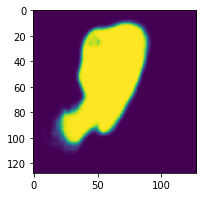

True


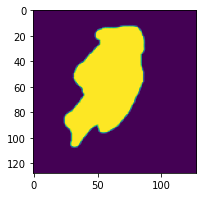


Sample Prediction after epoch 41

Epoch 42/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0322 - dice_coef: 0.9563 - val_loss: 0.0312 - val_dice_coef: 0.9576
Predict


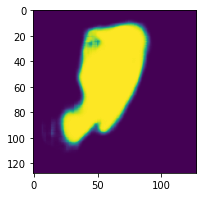

True


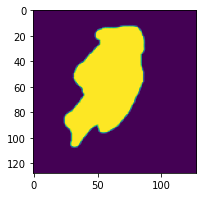


Sample Prediction after epoch 42

Epoch 43/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0317 - dice_coef: 0.9567 - val_loss: 0.0317 - val_dice_coef: 0.9555
Predict


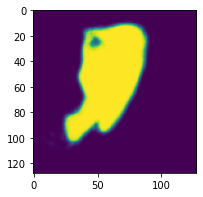

True


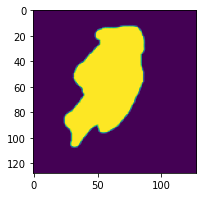


Sample Prediction after epoch 43

Epoch 44/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0317 - dice_coef: 0.9564 - val_loss: 0.0313 - val_dice_coef: 0.9563
Predict


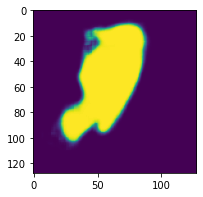

True


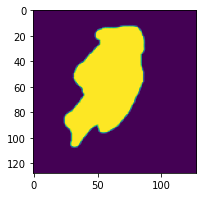


Sample Prediction after epoch 44

Epoch 45/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0315 - dice_coef: 0.9575 - val_loss: 0.0319 - val_dice_coef: 0.9577
Predict


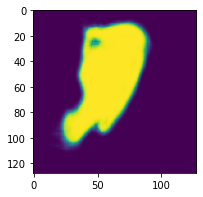

True


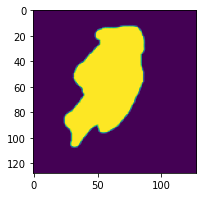


Sample Prediction after epoch 45

Epoch 46/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0310 - dice_coef: 0.9588 - val_loss: 0.0295 - val_dice_coef: 0.9595
Predict


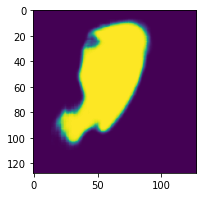

True


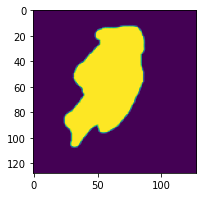


Sample Prediction after epoch 46

Epoch 47/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0300 - dice_coef: 0.9590 - val_loss: 0.0418 - val_dice_coef: 0.9423
Predict


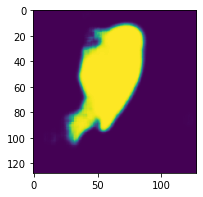

True


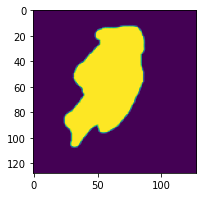


Sample Prediction after epoch 47

Epoch 48/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0324 - dice_coef: 0.9550 - val_loss: 0.0289 - val_dice_coef: 0.9598
Predict


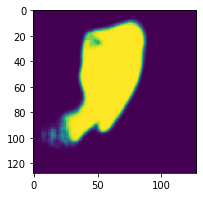

True


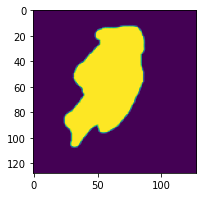


Sample Prediction after epoch 48

Epoch 49/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0280 - dice_coef: 0.9617 - val_loss: 0.0277 - val_dice_coef: 0.9617
Predict


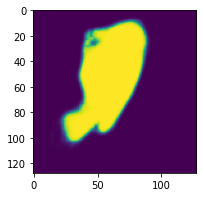

True


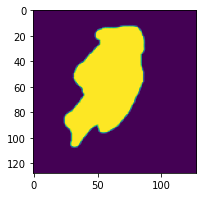


Sample Prediction after epoch 49

Epoch 50/60
854/854 [==============================] - 97s 113ms/step - loss: 0.0275 - dice_coef: 0.9624 - val_loss: 0.0272 - val_dice_coef: 0.9626
Predict


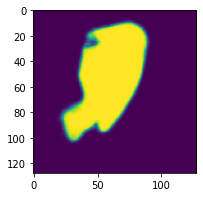

True


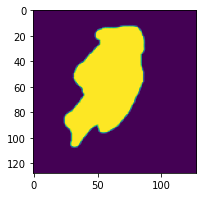


Sample Prediction after epoch 50

Epoch 51/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0271 - dice_coef: 0.9620 - val_loss: 0.0321 - val_dice_coef: 0.9544
Predict


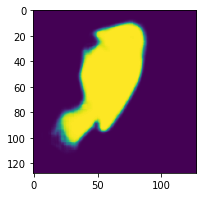

True


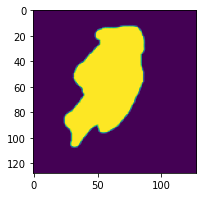


Sample Prediction after epoch 51

Epoch 52/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0280 - dice_coef: 0.9621 - val_loss: 0.0274 - val_dice_coef: 0.9625
Predict


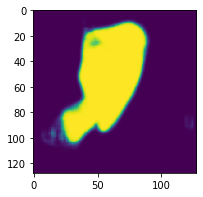

True


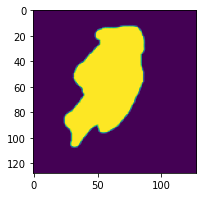


Sample Prediction after epoch 52

Epoch 53/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0264 - dice_coef: 0.9638 - val_loss: 0.0280 - val_dice_coef: 0.9612
Predict


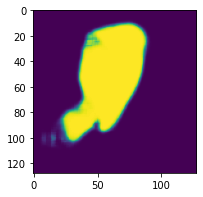

True


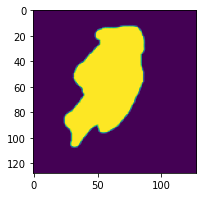


Sample Prediction after epoch 53

Epoch 54/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0293 - dice_coef: 0.9595 - val_loss: 0.0275 - val_dice_coef: 0.9623
Predict


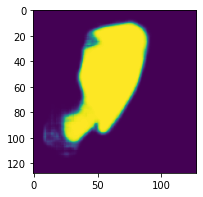

True


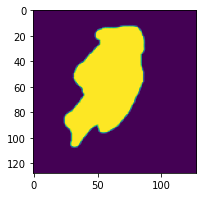


Sample Prediction after epoch 54

Epoch 55/60
854/854 [==============================] - 96s 113ms/step - loss: 0.0270 - dice_coef: 0.9629 - val_loss: 0.0250 - val_dice_coef: 0.9649
Predict


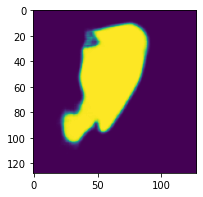

True


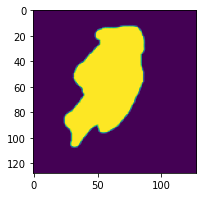


Sample Prediction after epoch 55

Epoch 56/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0246 - dice_coef: 0.9658 - val_loss: 0.0240 - val_dice_coef: 0.9668
Predict


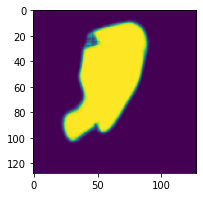

True


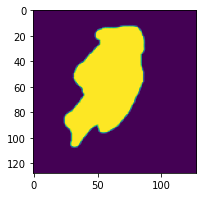


Sample Prediction after epoch 56

Epoch 57/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0245 - dice_coef: 0.9656 - val_loss: 0.0246 - val_dice_coef: 0.9661
Predict


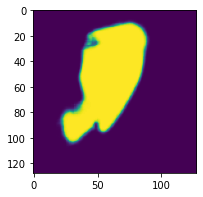

True


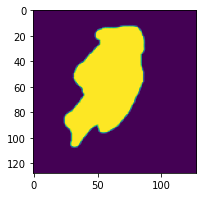


Sample Prediction after epoch 57

Epoch 58/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0256 - dice_coef: 0.9643 - val_loss: 0.0275 - val_dice_coef: 0.9619
Predict


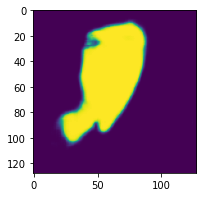

True


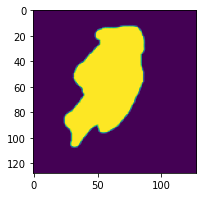


Sample Prediction after epoch 58

Epoch 59/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0284 - dice_coef: 0.9614 - val_loss: 0.0248 - val_dice_coef: 0.9658
Predict


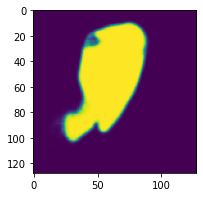

True


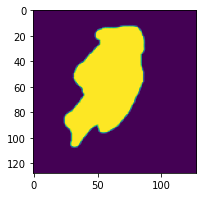


Sample Prediction after epoch 59

Epoch 60/60
854/854 [==============================] - 96s 112ms/step - loss: 0.0244 - dice_coef: 0.9663 - val_loss: 0.0238 - val_dice_coef: 0.9671
Predict


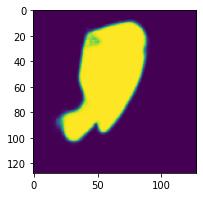

True


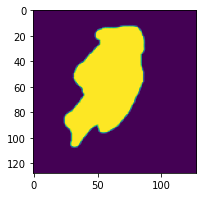


Sample Prediction after epoch 60



In [42]:
history = modelC.fit(xTrain, yTrain, epochs=60, batch_size=3, validation_data=(xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping(patience=5), DisplayCallback()])

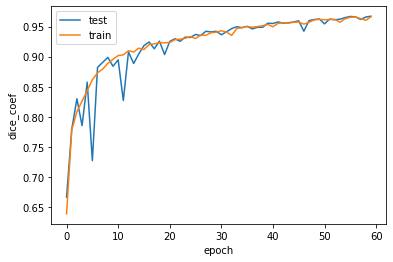

In [43]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

g

In [44]:
predc = modelC.predict(xTest)
print(predc.shape)

(451, 128, 128, 1)


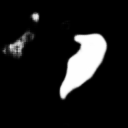

In [45]:
image.array_to_img(predc[4])

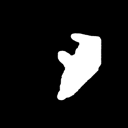

In [46]:
image.array_to_img(yTest[4])

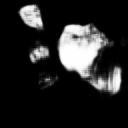

In [47]:
image.array_to_img(predc[2])

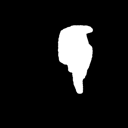

In [48]:
image.array_to_img(yTest[2])

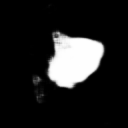

In [49]:
image.array_to_img(predc[3])

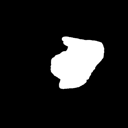

In [50]:
image.array_to_img(yTest[3])

In [51]:
# попробуем выполнить вторую предтерированную сеть

#Использование с VGG19

рассмотрим модель VGG19. Сначала нужно посмотреть на вид сети, чтобы понять, какие слои будут сопрягаться с какими слоями транспосе

In [52]:
from tensorflow.keras.applications import VGG19

In [53]:
def unet_pre_train_VGG19(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet", classifier_activation='sigmoid')
    # всем слоям, которые обучаемы, говорим, что они заморожены
    for layer in pre_trained_model.layers[:21]:
      layer.trainable = False
    x = pre_trained_model.layers[20].output # конец сверток
    block_5_out = pre_trained_model.layers[21].output
    block_4_out = pre_trained_model.layers[16].output
    block_3_out = pre_trained_model.layers[11].output
    block_2_out = pre_trained_model.layers[6].output 
    block_1_out = pre_trained_model.layers[3].output 
    img_input = pre_trained_model.inputs
    print(block_5_out)
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    #print(block_1_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    #x = bloc_transpose(x, block_5_out, numb_filter = [512,512])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_4_out, numb_filter = [512,256])
    

    # UP 3
    x = bloc_transpose(x,block_3_out, numb_filter = [256,128])

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [128,64])

    x = bloc_transpose(x,block_1_out, numb_filter = [64,32])



    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [54]:
modelD = unet_pre_train_VGG19(num_classes = 1, input_shape= (128, 128, 3))


80142336/80134624 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 512), dtype=tf.float32, name=None), name='block4_pool/MaxPool:0', description="created by layer 'block4_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0      

Epoch 1/30
854/854 [==============================] - 138s 158ms/step - loss: 0.3197 - dice_coef: 0.5036 - val_loss: 0.3653 - val_dice_coef: 0.3584
Predict


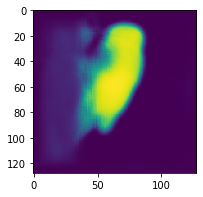

True


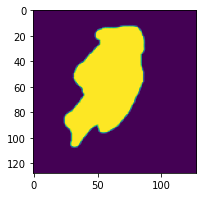


Sample Prediction after epoch 1

Epoch 2/30
854/854 [==============================] - 134s 157ms/step - loss: 0.1961 - dice_coef: 0.7501 - val_loss: 0.2227 - val_dice_coef: 0.6129
Predict


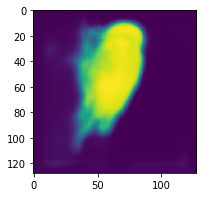

True


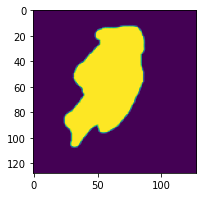


Sample Prediction after epoch 2

Epoch 3/30
854/854 [==============================] - 134s 157ms/step - loss: 0.1598 - dice_coef: 0.7969 - val_loss: 0.1746 - val_dice_coef: 0.6474
Predict


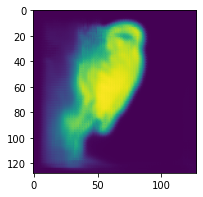

True


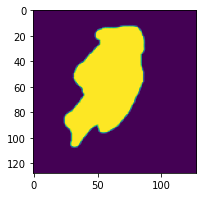


Sample Prediction after epoch 3

Epoch 4/30
854/854 [==============================] - 134s 157ms/step - loss: 0.1442 - dice_coef: 0.8188 - val_loss: 0.1081 - val_dice_coef: 0.8498
Predict


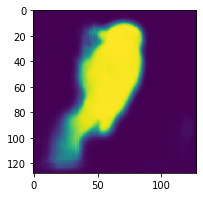

True


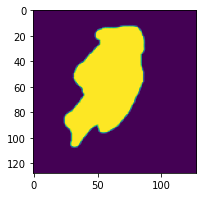


Sample Prediction after epoch 4

Epoch 5/30
854/854 [==============================] - 134s 157ms/step - loss: 0.1087 - dice_coef: 0.8620 - val_loss: 0.1821 - val_dice_coef: 0.8013
Predict


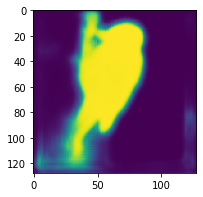

True


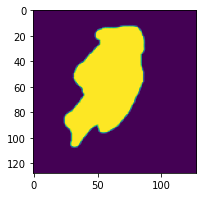


Sample Prediction after epoch 5

Epoch 6/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0993 - dice_coef: 0.8744 - val_loss: 0.1048 - val_dice_coef: 0.8369
Predict


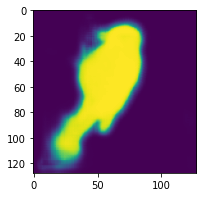

True


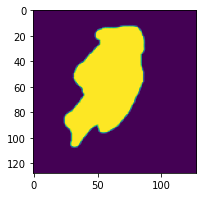


Sample Prediction after epoch 6

Epoch 7/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0925 - dice_coef: 0.8827 - val_loss: 0.0939 - val_dice_coef: 0.8578
Predict


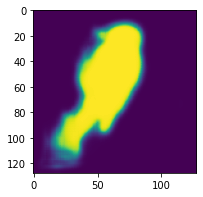

True


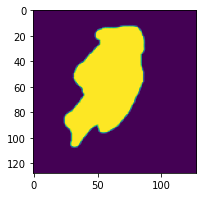


Sample Prediction after epoch 7

Epoch 8/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0780 - dice_coef: 0.8988 - val_loss: 0.0739 - val_dice_coef: 0.9044
Predict


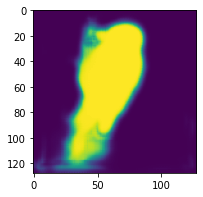

True


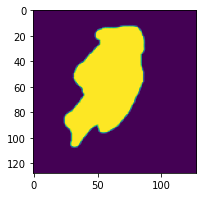


Sample Prediction after epoch 8

Epoch 9/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0804 - dice_coef: 0.8955 - val_loss: 0.0704 - val_dice_coef: 0.9034
Predict


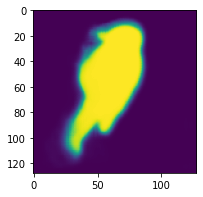

True


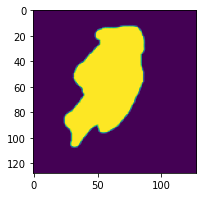


Sample Prediction after epoch 9

Epoch 10/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0717 - dice_coef: 0.9071 - val_loss: 0.0812 - val_dice_coef: 0.8819
Predict


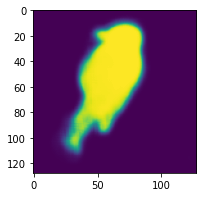

True


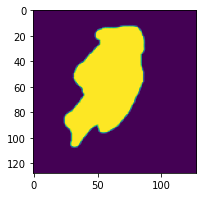


Sample Prediction after epoch 10

Epoch 11/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0724 - dice_coef: 0.9057 - val_loss: 0.0738 - val_dice_coef: 0.9071
Predict


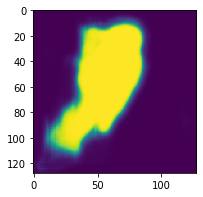

True


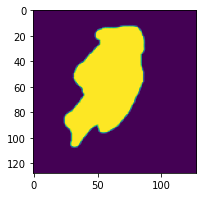


Sample Prediction after epoch 11

Epoch 12/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0638 - dice_coef: 0.9142 - val_loss: 0.0641 - val_dice_coef: 0.9146
Predict


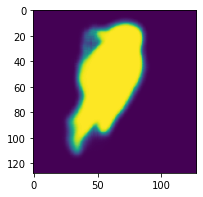

True


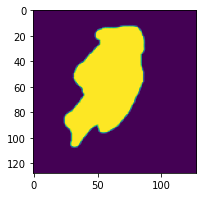


Sample Prediction after epoch 12

Epoch 13/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0701 - dice_coef: 0.9098 - val_loss: 0.0610 - val_dice_coef: 0.9194
Predict


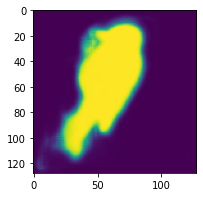

True


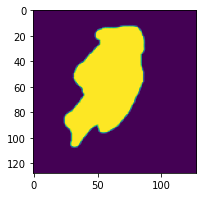


Sample Prediction after epoch 13

Epoch 14/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0620 - dice_coef: 0.9174 - val_loss: 0.0617 - val_dice_coef: 0.9193
Predict


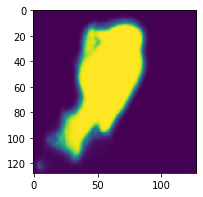

True


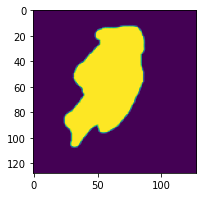


Sample Prediction after epoch 14

Epoch 15/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0583 - dice_coef: 0.9226 - val_loss: 0.0565 - val_dice_coef: 0.9237
Predict


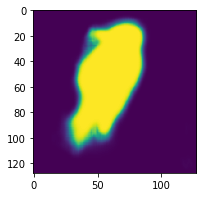

True


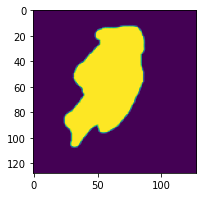


Sample Prediction after epoch 15

Epoch 16/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0565 - dice_coef: 0.9233 - val_loss: 0.0663 - val_dice_coef: 0.9109
Predict


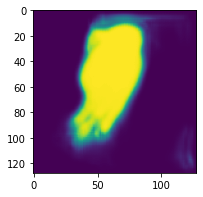

True


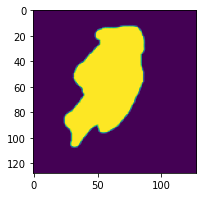


Sample Prediction after epoch 16

Epoch 17/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0572 - dice_coef: 0.9232 - val_loss: 0.0529 - val_dice_coef: 0.9273
Predict


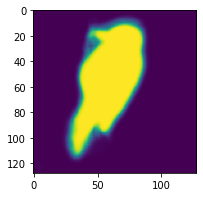

True


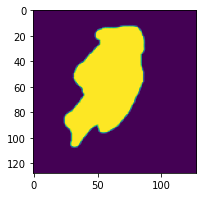


Sample Prediction after epoch 17

Epoch 18/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0588 - dice_coef: 0.9214 - val_loss: 0.0557 - val_dice_coef: 0.9268
Predict


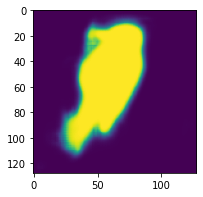

True


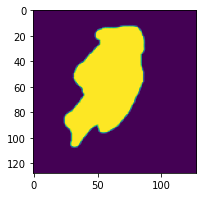


Sample Prediction after epoch 18

Epoch 19/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0517 - dice_coef: 0.9304 - val_loss: 0.0501 - val_dice_coef: 0.9329
Predict


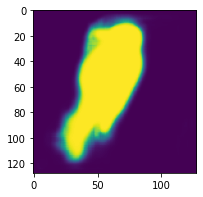

True


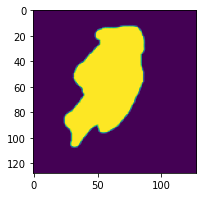


Sample Prediction after epoch 19

Epoch 20/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0503 - dice_coef: 0.9299 - val_loss: 0.0497 - val_dice_coef: 0.9325
Predict


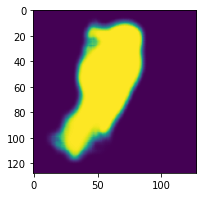

True


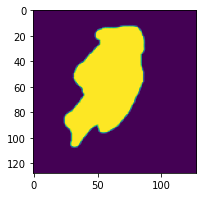


Sample Prediction after epoch 20

Epoch 21/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0477 - dice_coef: 0.9353 - val_loss: 0.0463 - val_dice_coef: 0.9374
Predict


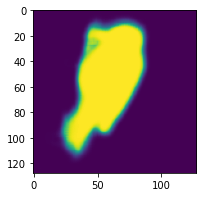

True


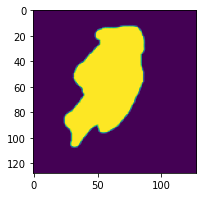


Sample Prediction after epoch 21

Epoch 22/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0462 - dice_coef: 0.9354 - val_loss: 0.0442 - val_dice_coef: 0.9397
Predict


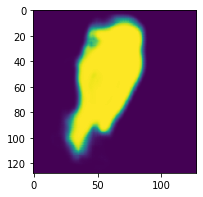

True


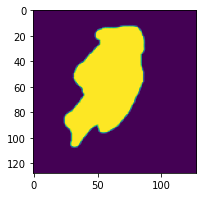


Sample Prediction after epoch 22

Epoch 23/30
854/854 [==============================] - 134s 158ms/step - loss: 0.0456 - dice_coef: 0.9387 - val_loss: 0.0484 - val_dice_coef: 0.9310
Predict


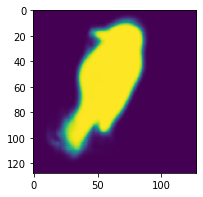

True


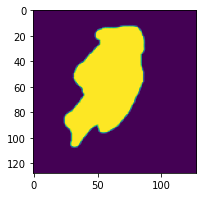


Sample Prediction after epoch 23

Epoch 24/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0438 - dice_coef: 0.9418 - val_loss: 0.0431 - val_dice_coef: 0.9395
Predict


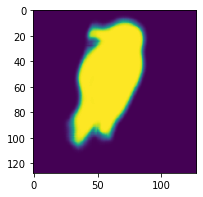

True


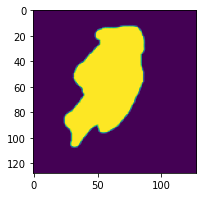


Sample Prediction after epoch 24

Epoch 25/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0417 - dice_coef: 0.9427 - val_loss: 0.0400 - val_dice_coef: 0.9442
Predict


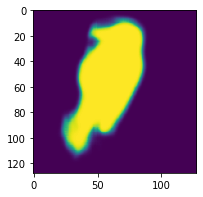

True


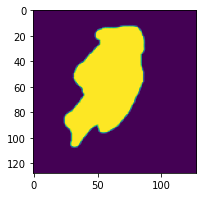


Sample Prediction after epoch 25

Epoch 26/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0406 - dice_coef: 0.9448 - val_loss: 0.0384 - val_dice_coef: 0.9477
Predict


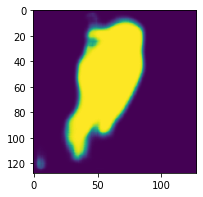

True


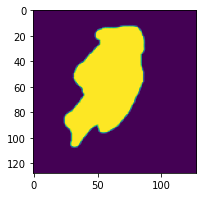


Sample Prediction after epoch 26

Epoch 27/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0391 - dice_coef: 0.9461 - val_loss: 0.0379 - val_dice_coef: 0.9462
Predict


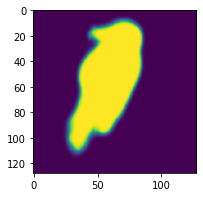

True


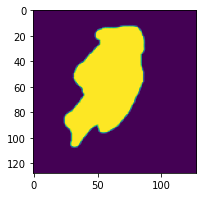


Sample Prediction after epoch 27

Epoch 28/30
854/854 [==============================] - 135s 158ms/step - loss: 0.0382 - dice_coef: 0.9481 - val_loss: 0.0360 - val_dice_coef: 0.9509
Predict


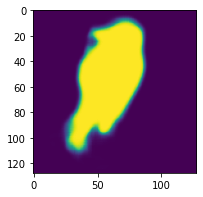

True


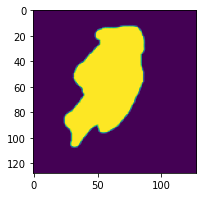


Sample Prediction after epoch 28

Epoch 29/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0399 - dice_coef: 0.9470 - val_loss: 0.0399 - val_dice_coef: 0.9465
Predict


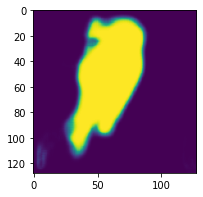

True


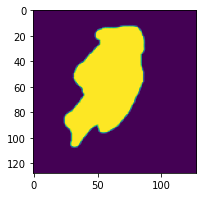


Sample Prediction after epoch 29

Epoch 30/30
854/854 [==============================] - 134s 157ms/step - loss: 0.0350 - dice_coef: 0.9514 - val_loss: 0.0345 - val_dice_coef: 0.9529
Predict


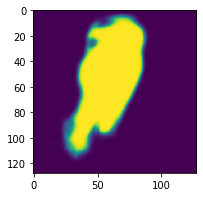

True


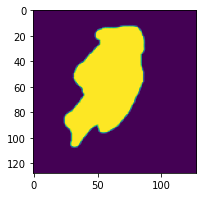


Sample Prediction after epoch 30



In [55]:
history = modelD.fit(xTrain, yTrain, epochs=30, batch_size=3, validation_data=(xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping(patience=5), DisplayCallback()])

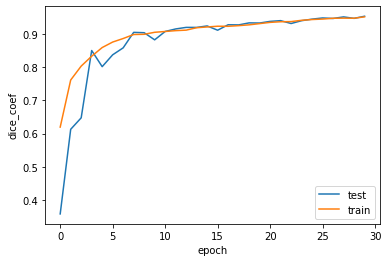

In [56]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [57]:
predc = modelD.predict(xTest)
print(predc.shape)

(451, 128, 128, 1)


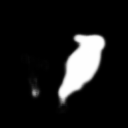

In [58]:
image.array_to_img(predc[4])

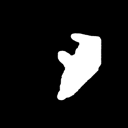

In [59]:
image.array_to_img(yTest[4])

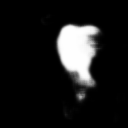

In [60]:
image.array_to_img(predc[2])

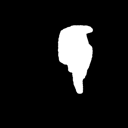

In [61]:
image.array_to_img(yTest[2])

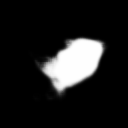

In [62]:
image.array_to_img(predc[3])

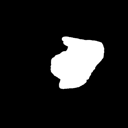

In [63]:
image.array_to_img(yTest[3])